In [12]:
import sys
#Change path specificly to your directories
sys.path.insert(1, '/home/codahead/Fishial/FishialReaserch')

import time
import torch
import os
import cv2
import matplotlib.pyplot as plt
import torchvision.models as models
import numpy as np
from torch import nn
from torch.optim import Optimizer, SGD
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from sklearn.neighbors import KDTree
from random import randint, randrange
from detectron2.structures import BoxMode
from module.segmentation_package.src.utils import get_dataset_dicts
from module.classification_package.src.utils import save_json, read_json
from module.classification_package.interpreter_classifier import ClassifierFC
from module.classification_package.interpreter_embeding import EmbeddingClassifier
from module.segmentation_package.interpreter_segm import SegmentationInference
# from module.segmentation_package.src.utils import resize_image

#@title do detection and display result
from detectron2.utils.visualizer import ColorMode
from detectron2.data import MetadataCatalog
from detectron2.utils.visualizer import Visualizer
import cv2


from PIL import Image
import numpy as np
import random
import sklearn.metrics.pairwise
import scipy.spatial.distance
import copy

import json
import time
import requests
import warnings
warnings.filterwarnings('ignore')
from os import listdir
from os.path import isfile, join
from shapely.geometry import Polygon
from shapely.validation import make_valid
from tqdm import tqdm


def get_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

def get_poly_from_coco(polys):
    poly_arrays = []
    for inst in polys:
        poly = inst['segmentation'][0]
        poly_array = []
        for i in range(int(len(poly)/2)):
            poly_array.append( (int(poly[2 * i]), int(poly[2 * i + 1])) )
        poly_arrays.append(poly_array)
    return poly_arrays

def get_poly_from_custom(polys, masks):
    poly_arrays = []
    for poly_id, poly in enumerate(polys):
        poly_array = []
        for i in range(int(len(poly)/2)):
            poly_array.append( ( int(poly[f"x{i + 1}"]), int(poly[f"y{i + 1}"]) ))
        poly_arrays.append([poly_array, False, masks[poly_id]])
    return poly_arrays

def draw_poly_on_img(img, poly, color):
    points = np.array(poly, np.int32)
    cv2.polylines(img, [points], isClosed=True, color=color, thickness=3)
    return img
    
def get_best_iou(poly, data):
    max_iou = 0
    MIN_IOU = 0.4
    poly = make_valid(Polygon(poly))
    for i in range(len(data)):
        poly_2 = make_valid(Polygon(data[i][0]))
        intersect = poly.intersection(poly_2).area
        union = poly.union(poly_2).area
        iou = intersect / union
        if iou > max_iou and iou > MIN_IOU:
            max_iou = iou
            data[i][1] = True
    return max_iou


In [13]:
model_segmentation = SegmentationInference('output_aug_custom_schedule_lr/model_0229999.pth', device='cuda')
model_segmentation.re_init_model(0.2)

In [14]:
dataset_val = get_dataset_dicts('FishialReaserch/datasets/fishial_collection/cache', "Train", 
                  json_file="FishialReaserch/datasets/fishial_collection/export.json")

  1%|          | 5/500 [00:00<00:54,  9.00it/s]

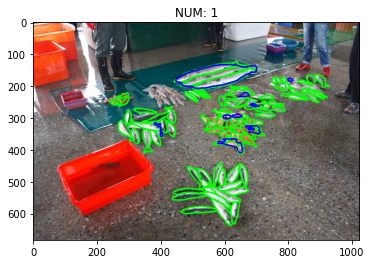

  3%|▎         | 15/500 [00:02<01:04,  7.57it/s]

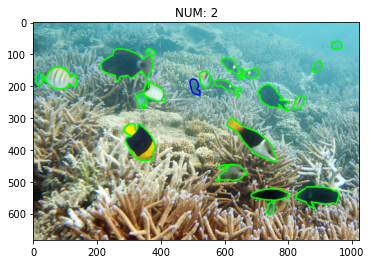

  4%|▎         | 18/500 [00:03<01:15,  6.41it/s]

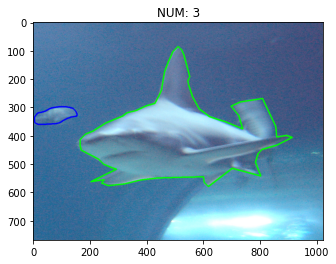

  5%|▍         | 24/500 [00:03<00:59,  8.00it/s]

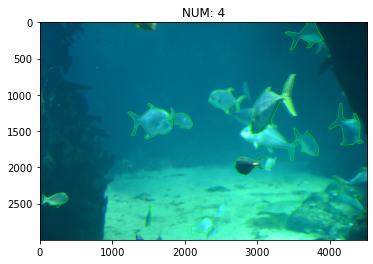

  5%|▌         | 25/500 [00:05<03:48,  2.08it/s]

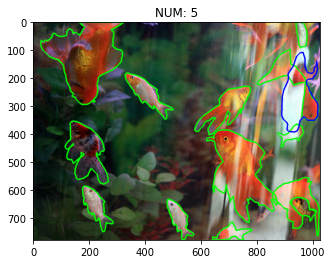

  8%|▊         | 40/500 [00:07<00:56,  8.15it/s]

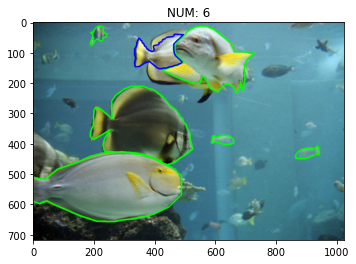

 10%|▉         | 48/500 [00:08<00:52,  8.55it/s]

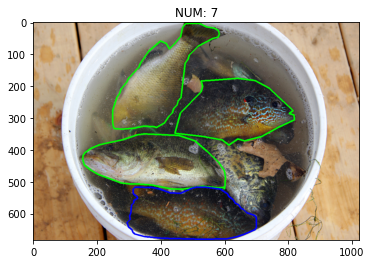

 11%|█         | 54/500 [00:09<00:51,  8.64it/s]

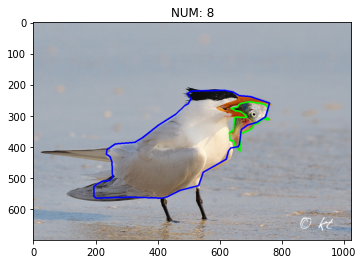

 17%|█▋        | 87/500 [00:12<00:45,  9.04it/s]

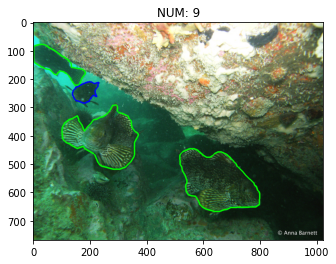

 20%|██        | 101/500 [00:14<00:44,  8.90it/s]

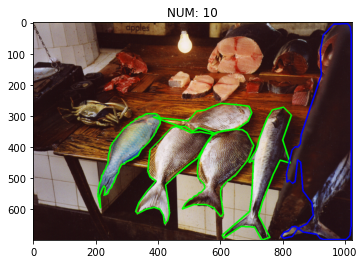

 23%|██▎       | 115/500 [00:16<00:41,  9.24it/s]

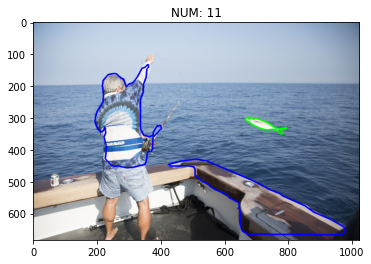

 23%|██▎       | 117/500 [00:16<00:52,  7.33it/s]

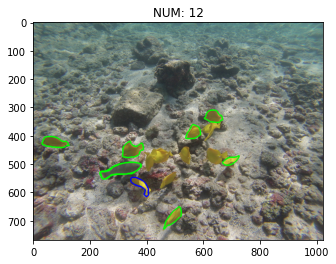

 24%|██▍       | 121/500 [00:17<00:48,  7.86it/s]

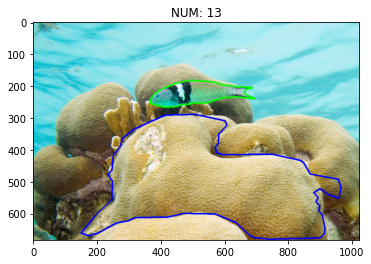

 37%|███▋      | 184/500 [00:24<00:34,  9.10it/s]

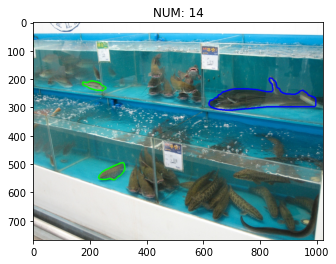

 38%|███▊      | 192/500 [00:25<00:33,  9.24it/s]

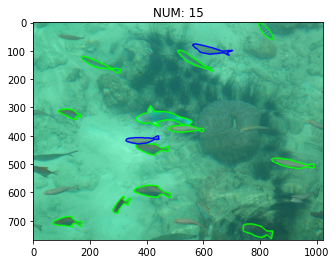

 40%|████      | 201/500 [00:26<00:33,  8.95it/s]

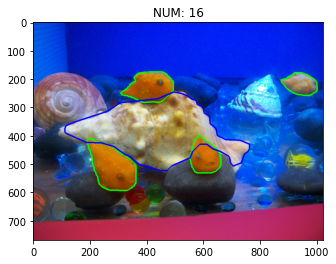

 43%|████▎     | 216/500 [00:27<00:33,  8.49it/s]

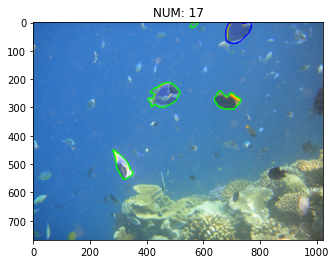

 43%|████▎     | 217/500 [00:28<00:44,  6.39it/s]

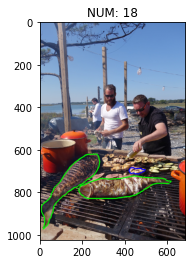

 45%|████▍     | 224/500 [00:29<00:32,  8.52it/s]

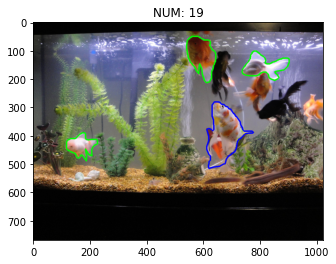

 52%|█████▏    | 261/500 [00:33<00:24,  9.78it/s]

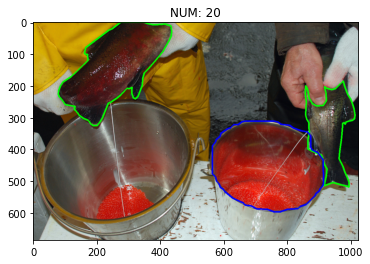

 55%|█████▌    | 275/500 [00:34<00:24,  9.13it/s]

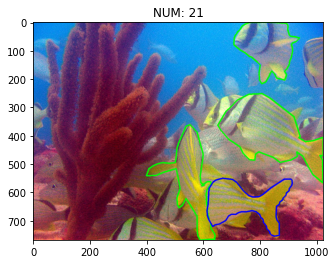

 58%|█████▊    | 292/500 [00:36<00:23,  8.88it/s]

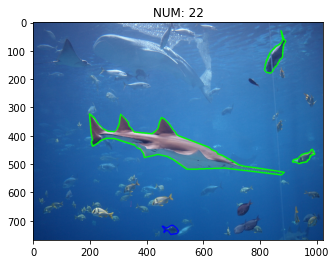

 61%|██████    | 306/500 [00:38<00:21,  9.24it/s]

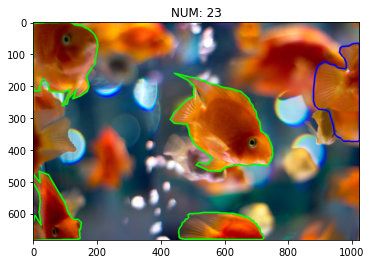

 67%|██████▋   | 336/500 [00:41<00:17,  9.39it/s]

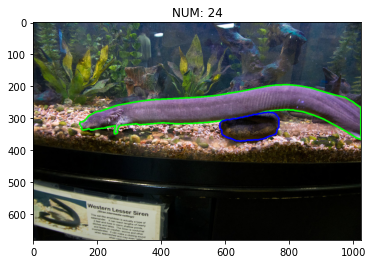

 67%|██████▋   | 337/500 [00:41<00:23,  6.95it/s]

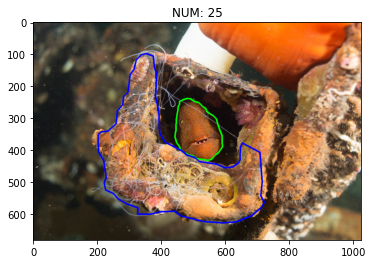

 70%|██████▉   | 348/500 [00:43<00:15,  9.68it/s]

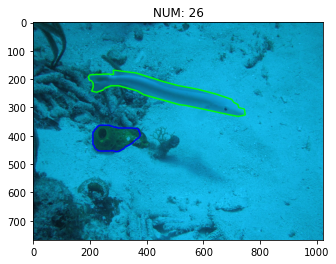

 74%|███████▍  | 371/500 [00:45<00:13,  9.34it/s]

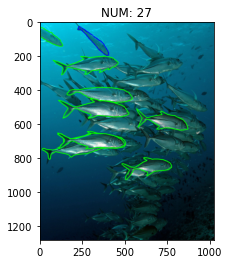

 75%|███████▌  | 376/500 [00:46<00:14,  8.27it/s]

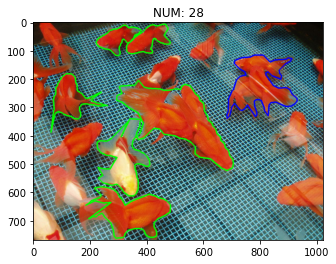

 85%|████████▍ | 424/500 [00:51<00:08,  9.25it/s]

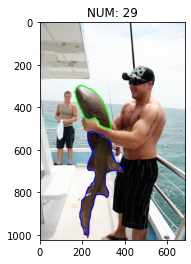

 86%|████████▌ | 428/500 [00:52<00:08,  8.18it/s]

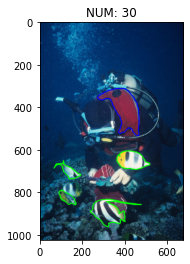

 90%|████████▉ | 449/500 [00:54<00:05,  9.54it/s]

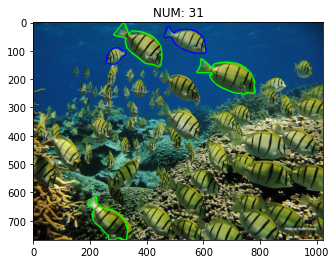

 91%|█████████▏| 457/500 [00:55<00:04,  9.33it/s]

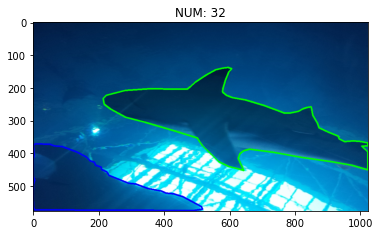

 95%|█████████▌| 476/500 [00:57<00:02,  9.22it/s]

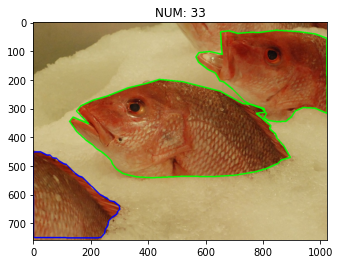

 96%|█████████▌| 480/500 [00:58<00:02,  8.28it/s]

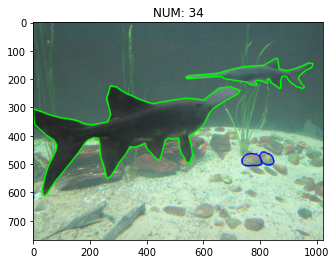

100%|██████████| 500/500 [01:00<00:00,  8.26it/s]


In [15]:
total_res = {}
def_folder = "unvalid_full"
cntt = 0
os.makedirs(def_folder, exist_ok=True)
for image_id in tqdm(range(len(dataset_val[:500]))):
    image_path = dataset_val[image_id]['file_name']
    annotations = dataset_val[image_id]['annotations']
    img = get_image(image_path)
    
    array, masks, outputs, _ = model_segmentation.simple_inference(img)
    true_poly = get_poly_from_coco(annotations)
    discovered = get_poly_from_custom(array, masks)
    
    for i in range(len(true_poly)):
        try:
            iou = get_best_iou(true_poly[i], discovered)
            draw_poly_on_img(img, true_poly[i], (0,255,0))
        except Exception as e:
            print("her!", e)
            break
    
    show_state = False
    for z in discovered:
        if not z[1]:
            show_state = True
            rand_value = randint(1e10, 9e10)
            name_base = f"{dataset_val[image_id]['image_id']}_{rand_value}"
            total_res.update({
                            name_base: copy.deepcopy(dataset_val[image_id])
                        })
            total_res[name_base]['annotations'] = [int(s) for s in list(np.array(z[0]).ravel())]
#             img_copy = img.copy()
            draw_poly_on_img(img, z[0], (0,0,255))
            
#             cv2.cvtColor(img_copy, cv2.COLOR_RGB2BGR)
            path = os.path.join(def_folder, f"{name_base}.png")
    if show_state:
        cntt += 1
        plt.title(f"NUM: {cntt}")
        plt.imshow(img)
        plt.show()
#             cv2.imwrite(path, img_copy)
# save_json(total_res, os.path.join(def_folder, "data_base_to_check.json"))

In [ ]:
len(total_res)

In [ ]:
rand_value = randint(1e10, 9e10)
total_res = {}
total_res.update({
                rand_value: dataset_val[image_id]
            })
total_res[rand_value]['annotations'] = list(np.array(discovered[0][0]).ravel()) 

In [ ]:
total_res

In [ ]:
cnt_ann = 0
for i in range(len(dataset_train)):
    cnt_ann += len(dataset_train[i]['annotations'])
print(cnt_ann)

In [ ]:
len(total_res)

In [ ]:
data = read_json('test_folder_img_to_check/data_base_to_check.json')

In [ ]:
coco_exp = read_json('FishialReaserch/datasets/fishial_collection/export.json')

In [ ]:
print(len(coco_exp['annotations']))
for i in coco_exp['images']:
    if i['id'] in list_of_image_id:
        print("-")
        img = get_image(os.path.join('FishialReaserch/datasets/fishial_collection/cache', i['file_name']))
        for iddx in range(len(coco_exp['annotations']) -1, -1, -1):
            if coco_exp['annotations'][iddx]['image_id'] == i['id']:
                try:
                    poly_coco = coco_exp['annotations'][iddx]['segmentation'][0]
                except Exception as e:
                    print("error: ", e)
                    continue
                poly = []
                for ad in range(int(len(poly_coco)/2)):
                    poly.append([poly_coco[2 * ad],poly_coco[2 * ad + 1]])
                print(iddx)
                draw_poly_on_img(img, poly, (255,0,0))
                del coco_exp['annotations'][iddx]
        plt.imshow(img)
        plt.show()
print(len(coco_exp['annotations']))

In [ ]:
print(len(coco_exp['annotations']))

In [ ]:
export = read_json('FishialReaserch/datasets/fishial_collection/export.json')

In [ ]:
export['annotations'] = export['annotations'][:len(export['annotations']) - 690]

In [ ]:
save_json(export, 'FishialReaserch/datasets/fishial_collection/export.json')